In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib qt
mpl.rc_file('matplotlibrc')
%matplotlib qt
import numpy as np
from scipy.stats import norm
from matplotlib.cm import magma

/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/matplotlib/__init__.py:908: MatplotlibDeprecationWarning: The backend.qt5 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)
/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/matplotlib/__init__.py:908: MatplotlibDeprecationWarning: The backend.qt5 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)
/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/matplotlib/__init__.py:908: MatplotlibDeprecationWarning: The backend.qt5 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)
/home/alispac

In [6]:
def plot_correlation(x, y, c=None, label_x=' ', label_y=' ', label_c=' ', **kwargs):

    
    print(x.shape, y.shape)
    mask = np.isfinite(x) * np.isfinite(y)
    
    x = x[mask]
    y = y[mask]
    c = c[mask]
    pearson_corr = np.corrcoef(x, y)[0, 1]

    plt.figure(figsize=(10, 10))
    plt.scatter(x, y, c=c, label='Correlation {:.02f}'.format(pearson_corr), **kwargs)
    
    if c is not None:
        plt.colorbar(label=label_c)
    plt.xlabel(label_x)
    plt.legend(loc='best')
    plt.ylabel(label_y)

In [7]:
def plot_histo(data, xlabel, show_fit=True, limits=None, **kwargs):

    mask = np.isfinite(data)
    
    if limits is not None:
        
        mask *= (data <= limits[1]) * (data >= limits[0])
    
    data = data[mask]
    mean = np.mean(data)
    std = np.std(data)
    
    try:
        
        data = data[~data.mask]
    
    except:
        
        pass
    
    n_entries = len(data)
    
    label='$N_{pixels}$ = ' + '{}\n'.format(n_entries)    
    label_fit= 'Mean : {:.2f}\n'.format(mean) + 'Std : {:.2f}'.format(std)
    
    if not show_fit:
        
        label += label_fit
    
    plt.figure(figsize=(10, 10))
    hist = plt.hist(data, **kwargs, label=label)
    
    if show_fit:
        
        bins = hist[1]
        
        bin_width = bins[1] - bins[0]        
        x = np.linspace(np.min(data), np.max(data), num=len(data)*10)
        y = n_entries * norm.pdf(x, loc=mean, scale=std) * bin_width
        plt.plot(x, y, color='r', label=label_fit)

    plt.xlabel(xlabel)
    plt.ylabel('count')
    plt.legend(loc='best')
    
    
  

In [10]:
from digicampipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from cts_core.camera import Camera
from digicampipe.utils.geometry import generate_geometry_from_camera
import matplotlib.pyplot as plt

def plot_camera_display(data, label, limits=None, **kwargs): 
    plt.figure()
    mask = np.isfinite(data)
    data = np.ma.masked_array(data, mask=~mask)
    cam = Camera('digicampipe/tests/resources/camera_config.cfg')
    geom = generate_geometry_from_camera(cam)
    cam_display = CameraDisplay(geom, **kwargs)
    cam_display.image = data
    cam_display.axes.set_title('')
    cam_display.axes.set_xticks([])
    cam_display.axes.set_yticks([])
    cam_display.axes.set_xlabel('')
    cam_display.axes.set_ylabel('')
    cam_display.cmap.set_bad('k')
    
    
    cam_display.axes.axis('off')
    cam_display.add_colorbar(label=label)
    cam_display.axes.get_figure().set_size_inches((10, 10))
    plt.axis('equal')
    if limits is not None:
        
        if not isinstance(limits, tuple):
            
            raise TypeError('Limits must be a tuple()')
            
        cam_display.colorbar.set_clim(vmin=limits[0], vmax=limits[1])

    
    cam_display.update()        

    return cam_display

In [11]:
from iminuit import Minuit
from probfit import Chi2Regression


def plot_calibration_ac_led(ac_levels, charge, gain, pixel=0, crosstalk=0.08, show_fit=False):
    
    
    photoelectron = charge[pixel]/gain[pixel] * (1 - crosstalk)
    
    mask = (photoelectron > 1) * (photoelectron < 300)
    
    x = ac_levels[mask]
    y = photoelectron[mask]
    
    func = lambda x, a, b: a * x**3 + b
    
    chi2 = Chi2Regression(func, x, y)
    
    m = Minuit(chi2)
    m.migrad()
       
    #coeff = np.polyfit(x, y, deg=4)
    
    coeff = [m.values['a'], 0, 0, 0, m.values['b']]
    x_fit = np.linspace(0, 1000, num=10000)
    y_fit = func(x_fit, **m.values)
    
    # y_fit = np.polyval(coeff, x_fit)
    
    diff = np.diff(y_fit)
    diff = np.append(diff, 0)
    
    mask = (y_fit > 1) * (y_fit < 2000) * (diff > 0)
    
    x_fit = x_fit[mask]
    y_fit = y_fit[mask]
    
    fig = plt.figure(figsize=(10, 10))
    axis = fig.add_subplot(111)
    axis.errorbar(ac_levels, photoelectron, label='AC LED {}'.format(pixel), marker='o', linestyle='None', color='k')
    
    if show_fit:
        axis.plot(x_fit, y_fit, 
                  label='f(x) = {:.2f}x⁴ + {:.2f}x³ + {:.2f}x² + {:.2f}x + {:.2f}'.format(coeff[0], coeff[1], coeff[2], coeff[3], coeff[4]), color='r')
    axis.set_ylim(1, np.max(photoelectron))
    plt.xlabel('DAC')
    plt.ylabel('$N_{p.e.}$')
    axis.set_yscale('log')
    plt.legend(loc='best')

In [12]:
def compute_transfer_function(charge, amplitude):
    
    n_pixels = len(charge)
    
    transfer = np.zeros(n_pixels)
    
    for pixel in range(n_pixels):
        
        x = charge[pixel]
        y = amplitude[pixel]
        mask = (y < 3000) * (y > 20)
        
        coeff = np.polyfit(x[mask], y[mask], deg=1)
        
        transfer[pixel] = coeff[0]
    
    transfer[transfer < 0] = np.nan
    transfer[transfer > 1] = np.nan
    
    return transfer

In [13]:
def plot_transfer_function(charge, amplitude, pixel):
    
    x = charge[pixel]
    y = amplitude[pixel]
    
    mask = (y < 3000) * (y > 20)
    
    coeff = np.polyfit(x[mask], y[mask], deg=1)
    
    x_fit = np.linspace(np.min(x), np.max(x[mask]), num=len(x)*10)
    y_fit = np.polyval(coeff, x_fit)
        
    plt.figure(figsize=(10, 10))
    plt.errorbar(x, y, label='Pixel {}'.format(pixel), marker='o', linestyle='None', color='k')
    plt.plot(x_fit, y_fit, color='r') #, label='f(x) = {:.02f} x + {:.02f}'.format(coeff[0], coeff[1]))
    plt.xlabel('charge [LSB $\cdot$ ns]')
    plt.ylabel('amplitude [LSB]')
    plt.legend(loc='best')

In [14]:
def compute_amplitude_baseline(charge, amplitude):

    n_pixels = len(charge)    
    baseline = np.zeros(n_pixels)
    
    for pixel in range(n_pixels):
        
        x = charge[pixel]
        y = amplitude[pixel]
        mask = (y < 3000) * (y > 20)
        
        coeff = np.polyfit(x[mask], y[mask], deg=1)
        
        baseline[pixel] = coeff[1]
        
    return baseline

In [15]:
def mask_outliers(data, n=3):
    
    mask = np.abs(data - np.mean(data)) < (n * np.std(data))
    
    return np.ma.masked_array(data, mask=~mask)

In [18]:
a = np.load('fmpe/fmpe_results.npz')
gain = a['gain']
baseline = a['baseline']
sigma_e = a['sigma_e']
sigma_s = a['sigma_s']
chi_2 = a['chi_2']
ndf = a['ndf']

gain_error = a['gain_error']
baseline_error = a['baseline_error']
sigma_e_error = a['sigma_e_error']
sigma_s_error = a['sigma_s_error']

b = np.load('ac_scan_run/mpe_results.npz')
amplitude = b['amplitude']
charge = b['charge']
ac_levels = b['ac_levels']
time = b['time']

c = np.load('output/dark_count_rate.npz')
dark_count_rate = c['dcr']

T = np.array([22.952428317761687, 23.26220755201969, 23.106668502533754, 22.200710364609403, 22.106867389032296, 22.69752611766469, 22.689570571292236, 22.909890498382442, 22.137065993629776, 22.22847359786838, 22.74152515984704, 23.085237234754896, 22.90501975570543, 22.81718402942997, 22.219706261049755, 22.270361984890684, 22.7908820189741, 22.30802906159292, 22.676906640332007, 23.275683273426093, 22.38677273487129, 22.26873840399835, 22.85972184880921, 22.51178846358128, 22.626413274580308, 22.65092934605461, 22.105568524318425, 22.669275810138014, 23.7297988490129, 23.005194696762654, 23.391769307228223, 22.111251057441606, 22.236753860419295, 22.96152037075878, 23.238340912902327, 23.22242982015742, 23.174858900011927, 22.258347486287388, 22.011563190652087, 23.399562495511443, 22.891868750477492, 22.12635035974035, 23.11705942024471, 22.68388803816906, 23.01363731740281, 22.612612836995442, 22.29081910413414, 22.734543762009988, 23.292893230884864, 22.609852749478467, 22.30640548070058, 22.805169530826674, 22.83439398688875, 23.11705942024471, 22.99805094083637, 21.977792708091464, 21.96123218298962, 21.897912528188456, 21.439413284192334, 21.474969705734527, 21.316670568731617, 21.640087882485254, 22.424602169662755, 23.43820372074908, 23.01802098581212, 23.365792012950823, 22.134468264202035, 22.250879014182633, 22.938140805909118, 23.466129312097287, 22.684050396258293, 22.87173634741251, 22.441000336675366, 22.28188940922628, 23.885175540409595, 23.37991716671416, 22.566827855831523, 22.094203458072066, 21.24458357711183, 20.821640754657903, 20.940324517887777, 20.98058932401775, 21.681651553329097, 22.88147783276653, 22.460970381651116, 22.768476602659845, 22.589882704502717, 22.304944257897475, 22.840076520011927, 23.40069900213608, 22.562606545511443, 22.38206435028351, 22.918657835201067, 22.422816230681182, 22.748344199594857, 22.85095451199059, 22.176031935045874, 22.80516953082667, 22.717333804551213, 22.32199185726702, 22.34407255740281, 22.040787646714158, 20.908015258130263, 20.878790802068185, 21.808615579109894, 21.27526925597701, 21.588133293930454, 21.333555810011923, 21.59073102335819, 22.456586713241805, 23.71940793130194, 22.99886273128254, 23.237691480545394, 22.178954380652083, 22.252177878896504, 22.772860271069153, 23.00275932542415, 23.1251773247064, 23.062344744172936, 22.295365130632682, 22.21629674117585, 23.659010722106984, 23.410278129400876, 23.429761100108923, 22.957136702349466, 22.020330527470705, 21.775819245084676, 22.976132598789814, 22.269063120176817, 21.244908293290298, 21.377554852194272, 20.765951930050726, 20.896812549973134, 20.947955348081763, 21.1544748375871, 21.82988448879951, 23.138165971845098, 22.75256550991493, 22.81328743528836, 22.370536925947917, 22.061082407868376, 22.51747099670446, 23.194341870719978, 22.28611071954636, 22.14469682382376, 22.997076792300966, 22.61683414731552, 22.884887352640444, 23.02467766747071, 22.144047391466827, 22.42054321743191, 22.93635486692754, 22.78714778292173, 22.976457314968282, 22.67853022122434, 21.905705716471676, 22.04955498353278, 21.72548823742221, 21.176230821544422, 20.790143285346556, 20.20987547442512, 20.356160112824735, 20.614634190884864, 22.232694908188456, 21.625475654454213, 22.042735943784965, 21.622390850758777, 21.790756189294182, 22.596864102339765, 23.399887211689915, 22.79591511974035, 23.07582046557934, 21.815272260768477, 21.8759941861419, 22.5705620918839, 23.32406598401775, 22.97726910541445, 22.959734431777207, 22.351541029507562, 22.22246634856673, 23.85367807109825, 23.555263903086615, 23.207492875947914, 22.993180198159358, 22.33108391026411, 22.219706261049755, 23.639852467577406, 23.310427904522115, 22.618782444386326, 22.127649224454217, 21.107553349798543, 20.516407546898446, 20.413797234502717, 20.317843603765567, 21.021178846326187, 21.962855763881954, 21.52741136855703, 21.73863924265014, 21.649829367839278, 21.618981330884868, 22.160770274657903, 23.010065439439664, 22.47980392000223, 22.438727323426086, 22.138364858343643, 21.85699828970155, 22.306567838789817, 23.328936726694764, 22.44035090431843, 22.284649496743256, 23.283638819798547, 22.919144909468766, 22.904857397616194, 22.8673526790032, 22.089170357305818, 22.446195795530844, 22.97337251127284, 22.634368820952766, 22.771561406355282, 22.8808284004096, 22.303970109362073, 22.58144008386256, 22.466003482417364, 22.055724590923663, 22.239189231757805, 21.9803904375192, 20.881226173406695, 20.71691978710213, 22.391318761369835, 21.4517524989741, 21.83183278587032, 21.069886273096312, 21.383237385317454, 21.745458282397966, 22.88894630487129, 22.173758921796605, 22.481589858983803, 21.66379216351338, 21.791892695918815, 22.448468808780113, 23.660634302999323, 22.543610649071095, 22.745259395899417, 22.02568834441542, 22.162069139371773, 22.603520783998352, 23.261071045395052, 22.89641477697604, 22.554326282960524, 23.84361186956576, 23.34777026504588, 23.072248587616198, 22.94122560960456, 22.32426487051629, 22.261757006161293, 23.862932482184576, 23.433657694250535, 23.107642651069153, 22.501559903959553, 21.910251742970225, 21.71931863003133, 23.065754264046845, 22.33887709854733, 21.38161380442512, 22.010426684027447, 21.721754001369835, 22.18918294027381, 21.691068322504652, 21.391030573600677, 21.73052133818846, 22.51698392243676, 22.051990354871286, 22.19843735136013, 21.975844411020656, 21.639113733949852, 22.152977086374683, 23.309129039808244, 22.631771091525025, 22.43970147196149, 22.024876553969253, 21.97259724923598, 22.3911564032806, 23.35393987243676, 22.78178996597701, 22.816696955162264, 22.545071871874196, 22.419244352718035, 22.63972663789748, 22.940900893426086, 22.13804014216518, 22.532083224735498, 23.159921955802425, 22.799324639614255, 22.918820193290298, 22.46681527286353, 21.806180207771387, 22.177655515938213, 22.04598310556964, 21.353038780719974, 20.95120250986644, 20.95298844884801, 21.29605109139893, 21.91999322832425, 23.322929477393114, 22.240163380293215, 22.66830166160262, 21.650154084017746, 21.677105526830548, 22.156548964337823, 23.396964766083705, 22.37394644582182, 22.690382361738408, 21.877130692766535, 21.9784421404484, 22.317283472679243, 23.23022300844064, 22.585986110361105, 22.6355053275774, 23.97219947623889, 23.930635805395053, 23.227625279012898, 22.614561134066246, 22.029747296646264, 21.874045889071095, 23.678980767082734, 23.281203448460037, 23.163169117587096, 23.24321165557934, 22.543935365249567, 22.22636294270834, 23.28867192056479, 22.928561678644325, 22.85793590982764, 22.372809939197186, 21.26000759558904, 20.770335598460036, 20.878790802068185, 20.87554364028351, 21.550141501049755, 22.59053213685965, 22.297800501971192, 22.65920960860553, 22.086410269788843, 21.761207017053636, 22.204119884483315, 23.162519685230162, 22.56374305213608, 22.59783825087517, 22.252177878896504, 21.939313840943065, 22.181714468169062, 22.89121931812056, 22.355924697916876, 22.376868891428032, 23.290295501457127, 22.979704476752957, 22.913462376345585, 22.729185945065275, 21.951165981457127, 22.21288722130194, 22.818320536054607, 22.564392484493013, 22.9457716361031, 23.20895409875102, 22.43353186457061, 22.642811441592922, 22.63631711802357, 22.38385028926508, 22.56682785583152, 22.23042189493918, 21.082874920235014, 20.94681884145713, 21.791080905472647, 21.281438863367892, 21.567676174686998, 21.169411781796605, 21.49640097351338, 22.473634312611345, 23.423266776539574, 22.601247770749076, 22.99415434669476, 22.045171315123472, 22.158172545230162, 22.56033353226217, 23.26269462628739, 22.394078848886807, 22.655150656374683, 21.67710552683055, 21.832157502048787, 22.30721727114675, 22.960546222223375, 22.683888038169055, 22.344397273581276, 23.631247488848015, 23.228274711369835, 22.74152515984704, 22.61829537011862, 22.05345157767439, 22.19064416307691, 23.957262532029386, 23.65527648605461, 22.970774781845105, 22.60741737813996, 21.904082135579337, 21.97292196541445, 23.195803093523086, 22.657423669623952, 21.690743606326183, 21.529846739895536, 20.875381282194272, 20.92571228985674, 21.027997886074004, 21.08368671068118, 21.883787374425122, 22.959734431777203, 22.512600254027447, 22.722042189138985, 22.464379901525025, 22.070823893222403, 22.31647168223307, 22.97142421420203, 22.33157098453181, 22.400248456277687, 22.237240934687005, 21.818519422553152, 22.188046433649177, 22.9727230789159, 22.535655102698637, 22.651416420322306, 22.8033835918451, 22.38125255983734, 22.458210294134137, 22.754838523164207, 22.117258306743256, 22.612125762727736, 22.904045607170026, 22.45545020661717, 22.590207420681182, 22.319069411660813, 21.89856196054539, 22.418594920361105, 22.324751944783994, 21.603557312407656, 21.285497815598738, 20.46818719439602, 20.609601090118616, 21.22152872844064, 22.231883117742285, 21.77695575170931, 22.10702974712153, 21.681976269507565, 21.823065449051693, 22.510002524599706, 23.400536644046845, 22.73551791054539, 22.860533639255383, 21.71103836748041, 21.810401518091464, 22.571698598508537, 23.50639411822726, 22.594266372912028, 22.708241751554123, 23.7817534375677, 23.87040095428933, 23.25879803214578, 22.868326827538603, 22.17538250268894, 22.015135068615226, 23.726876403406692, 23.392094023406695, 23.345497251796605, 22.99805094083637, 22.290656746044906, 22.017732798042967, 23.21690964512347, 22.914274166791753, 22.908753991757806, 22.59199335966275, 21.731820202902327, 21.20480584524956, 21.165515187654997, 21.000721727082734, 21.340050133581276, 21.915122485647235, 21.505330668421237, 21.659246137014836, 21.684573998935306, 21.584886132145776, 22.254775608324245, 22.935543076481373, 22.44652051170931, 22.56017117417294, 22.10443201769379, 21.66022028555024, 22.054101010031328, 23.120306582029386, 22.744772321631714, 22.82692551478399, 23.373098126966344, 23.121118372475557, 22.924340368324245, 22.964929890632682, 21.964316986685063, 22.086085553610374, 22.900960803474582, 22.611963404638505, 22.930509975715125, 22.855175822310667, 21.94661995495858, 21.977792708091464, 22.1218043332418, 22.1463204047161, 22.74590882825635, 22.64589624528836, 21.568000890865466, 21.780202913493987, 23.144497937325212, 22.063030704939184, 22.416971339468766, 21.355636510147715, 21.432107170176813, 21.97292196541445, 23.289970785278662, 22.23220783392075, 22.58192715813026, 21.75844692953666, 21.918044931253444, 22.502696410584186, 23.074196884686998, 22.32946032937177, 22.60741737813996, 21.91918143787808, 22.15265237019621, 22.61439877597701, 23.009903081350433, 22.651741136500775, 22.306405480700583, 23.431059964822794, 23.105044921641415, 22.65791074389166, 22.638427773183608, 22.30137237993433, 22.186260494667604, 23.69700251498768, 23.297439257383413, 22.53581746078787, 22.078617081505627, 21.697562646074005, 21.707953563784965, 23.564031239905237, 23.145634443949856, 22.892842899012898, 22.787797215278662, 22.352515178042967, 22.743798173096312, 22.115634725850917, 21.637814869235985, 22.049717341622017, 22.720580966335884, 22.449605315404753, 22.46973771846974, 21.938502050496894, 21.80520605923598, 22.306405480700583, 22.949343514066243, 22.202009229323277, 22.25412617596731, 22.180253245365954, 21.93428074017682, 22.384499721622014, 23.012825526956643, 22.515847415812125, 22.57575755073938, 22.931808840429, 22.359983650147715, 22.313549236626866, 22.501072829691854, 22.120180752349466, 22.52932313721852, 22.682589173455185, 22.209315343338794, 22.00312057001193, 21.75114081552114, 21.47432027337759, 22.303158318915905, 23.01655976300902, 22.56082060652987, 22.386285660603587, 21.71298666455121, 21.985748254463918, 22.709215900089525, 23.456063110564795, 22.432882432213674, 22.817833461786908, 22.086085553610374, 21.893691217868383, 22.563905410225317, 23.162194969051697, 22.40073553054539, 22.751753719468763, 21.66671460911959, 21.846769730079824, 22.282376483493984, 23.18102850740281, 22.773672061515324, 22.815722806626862, 23.861471259381474, 23.82786313491009, 23.66794041701484, 23.124203176170997, 21.962206331525024, 21.65372596198089, 23.32065646414384, 23.0751710332224, 22.780653459352376, 22.764904724696702, 21.833781082941123, 21.417494942145776, 22.60059833839214, 22.27880460553084, 22.837316432494955, 23.00129810262105, 22.193241892504656, 21.958796811651116, 21.910251742970225, 21.723864656529873, 22.34358548313511, 23.089133828896507, 22.643298515860614, 22.722204547228223, 22.448468808780117, 22.218407396335888, 22.42573867628739, 23.207330517858683, 22.541175277732588, 22.5695879433485, 22.144534465734527, 21.850016891864502, 22.229447746403782, 22.978405612039086, 22.22084276767439, 22.307217271146747, 23.469376473881958, 23.26236991010892, 23.504121104977983, 22.88115311658807, 21.806180207771387, 21.668987622368864, 21.926812268072062, 21.776306319352376, 22.389695180477496, 22.635180611398933, 21.472696692485254, 21.472047260128317, 21.878429557480406, 21.997600394977983, 22.72902358697604, 22.906318620419295, 22.03981349817876, 22.4306094189644, 22.240163380293207, 22.49863745835335, 22.944148055210764, 21.643984476626866, 21.654375394337823, 22.362743737664694, 23.81682278484219, 23.091244484056546, 23.23444431876072, 22.02000581129224, 21.85391348600611, 22.573971611757806, 23.644560852165185, 22.623815545152567, 23.093355139216584, 21.786210162795633, 21.94661995495858, 22.288870807063333, 23.052440900729678, 23.093030423038115, 22.812800361020656, 23.836955187907176, 23.360434196006114, 22.419569068896507, 21.87079872728642, 21.32543790555024, 21.440712148906204, 23.273410260176817, 22.900960803474586, 22.05978354315451, 21.743509985327155, 21.361156685181665, 21.63732779496828, 23.739540334366925, 23.41141463602551, 22.767989528392146, 21.976980917645296, 22.053126861495922, 23.225676981942094, 21.891905278886806, 21.21649562767439, 21.744159417684088, 23.072248587616198, 22.71895738544355, 23.031171991040054, 22.530297285753928, 21.857972438236953, 22.348618583901356, 23.280878732281572, 22.68145266683055, 22.910377572650145, 22.333032207334917, 21.901809122330064, 22.194378399129292, 23.454439529672452, 22.942686832407663, 23.156999510196215, 22.97012534948817, 22.383200856908147, 21.998249827334917, 21.535691631107948, 21.16226802587032, 21.82858562408564, 22.440026188139964, 21.737665094114742, 21.68652229600611, 21.773708589924635, 21.289069693561878, 21.804394268789817, 22.178142590205915, 23.134594093881958, 22.703858083144812, 22.365341467092435, 22.82043119121464, 23.548444863338798, 21.40093441704393, 21.395738958188456, 21.88459916487129, 21.581314254182633, 21.751627889788846, 22.592805150108923, 23.914399996471673, 22.7764321490323, 22.914436524880987, 21.946295238780113, 22.188046433649173, 22.880666042320367, 23.735643740225314, 22.72415284429903, 22.864592591486225, 24.274185522213674, 24.242525694813093, 23.916997725899417, 23.38933393588972, 22.229123030225313, 21.63732779496828, 22.361282514861593, 22.064004853474582, 22.18837114982764, 22.3901822547452, 21.580015389468766, 21.295564017131227, 22.642486725414447, 22.322966005802424, 21.7490301603611, 21.505168310332003, 21.918044931253444, 23.313999782485254, 23.022079938042967, 22.975970240700576, 22.30283360273744, 21.27397039126314, 20.918568533930454, 21.96772650655897, 21.281925937635595, 21.138239028663723, 21.800497674648206, 23.25100484386256, 22.736167342902323, 22.70986533244646, 22.443760424192337, 21.980390437519205, 22.465191691971192, 23.312700917771387, 22.944148055210764, 23.057961075763625, 23.90157370742221, 23.764543480108927, 23.777856843426093, 23.063481250797572, 21.825663178479438, 21.495751541156448, 21.362780266074, 21.292803929614255, 21.803582478343642, 22.09274223526896, 21.354662361612313, 21.3108256775192, 21.438601493746162, 22.056374023280597, 22.154925383445487, 22.057510529905237, 22.725938783280597, 23.715836053338798, 22.324914302873225, 22.806468395540538, 21.680027972436754, 21.090505750429003, 21.39476480965305, 22.157198396694756, 20.896487833794662, 21.308552664269925, 21.785723088527934, 21.472371976306786, 21.49250437937177, 22.14420974955606, 23.263344058644325, 22.501235187781084, 22.923853294056546, 22.187397001292236, 22.482726365608436, 22.806630753629776, 23.509316563833462, 23.53042311543385, 23.25717445125344, 23.80253527298962, 23.302634716238895, 22.379466620855766, 21.40255799793627, 20.77991472572483, 20.855086521040054, 23.035555659449372, 22.547020168945004, 21.582288402718035, 21.264715980176817, 21.63846430159292, 23.21739671939118, 22.76214463717973, 22.821405339750044, 22.78049110126314, 21.853588769827642, 21.529846739895536, 22.379628978945, 21.641549105288355, 21.39833668761619, 21.446881756297085, 21.030270899323273, 21.0520268832806, 22.103782585336855, 21.24750602271804, 20.892915955831523, 21.47432027337759, 22.43742845871222, 22.151353505482344, 22.373621729643354, 22.13901429070058, 22.128623372989622, 22.48451230459001, 23.82623955401775, 23.381378389517263, 23.6523540404484, 23.26269462628739, 22.483051081786908, 22.113524070690882, 21.353201138809208, 20.708314808372737, 21.011762077150628, 21.42236568482279, 22.21986861913899, 22.008965461224346, 21.887196894299027, 22.756137387878077, 23.765192912465857, 22.625439126044906, 23.116734704066246, 22.29731342770349, 21.658596704657903, 21.837028244725797, 22.606767945783027, 20.946656483367896, 21.76429182074908, 21.559720628314547, 21.356285942504652, 21.871772875821822, 22.440513262407663, 20.82975865911959, 21.15999501262105, 21.407104024434815, 21.06160601054539, 21.39070585742221, 22.0943658161613, 23.13540588432813, 22.84316132370737, 22.89203110856673, 24.796653853367893, 24.654752883377594, 25.13549518559874, 23.754152562397966, 22.497013877461008, 21.82988448879951, 22.371348716394085, 21.86511619416324, 21.349142186578366, 21.238738685899417, 21.552576872388258, 23.138165971845098, 22.883101413658874, 23.01444910784898, 23.276170347693792, 22.661320263765568, 22.167914030584186, 23.168689292621046, 22.227661807422212, 22.00961489358128, 21.773546231835404, 21.08531029157352, 21.248155455074972, 22.74542175398865, 22.060432975511443, 22.12001839426023, 21.84839331097216, 20.751339702019685, 20.549528597102128, 21.68652229600611, 20.898111414687, 20.90070914411474, 21.659895569371773, 22.89609006079757, 22.563905410225317, 22.841862458993496, 24.18407678268894, 23.893780519138993, 23.956613099672452, 23.62848740133104, 22.221654558120566, 21.56296779009922, 21.44980420190329, 21.900023183348498, 21.781988852475557, 21.687171728363044, 22.76571651514287, 23.689858759061398, 22.807767260254412, 23.473922500380503, 23.104395489284478, 22.426063392465856, 22.776432149032296, 23.351017426830555, 21.770461428139964, 22.144047391466827, 21.90115968997313, 21.5816389703611, 22.411938238702522, 23.221455671622017, 21.778579332601645, 22.16206913937177, 21.366352144037144, 20.681850439827638, 20.9880577961225, 21.983150525036177, 21.24880488743191, 21.540075299517262, 22.12570092738341, 22.028610790021627, 22.320205918285453, 22.7514290032903, 23.871375102824732, 23.615823470370806, 23.650730459556065, 24.617410522853827, 24.031297820719978, 22.008965461224346, 21.37804192646197, 21.638626659682153, 23.257823883610378, 22.38725980913899, 22.90891634984704, 23.19271828982764, 22.689083497024537, 22.657261311534718, 23.720382079837343, 23.21301305098186, 22.971748930380503, 22.734706120099226, 21.869662220661784, 21.912524756219497, 23.175021258101165, 22.553189776335884, 22.69233065880922, 22.528186630593893, 21.4392509261031, 21.27786698540475, 22.148268701786908, 21.262118250749076, 21.055274045065275, 21.594302901321335, 21.32056716287323, 21.632619410380503, 23.412713500739383, 22.738927430419302, 22.39326705844064, 22.77708158138923, 23.86471842116615, 23.92576506271804, 24.370626227218526, 25.229825235443553, 23.08604902520106, 22.39732601067148, 21.80715435630679, 22.895278270351405, 23.854002787276716, 22.663430918925602, 23.49178189019622, 23.25279078284413, 22.931808840429003, 23.411576994114743, 23.943949168712216, 22.685511619061394, 23.153752348411537, 22.766041231321342, 22.20168451314481, 23.039614611680214, 23.620531854958585, 22.411775880613288, 22.775133284318425, 21.976169127199125, 21.325437905550242, 21.687658802630747, 22.35738592071998, 20.932693687693792, 21.972597249235985, 21.985585896374683, 21.941911570370806, 23.174209467654993, 24.073023849653055, 23.190932350846072, 23.191257067024537, 23.26821480132134, 24.996029586946946, 24.967941637509504, 24.803635251204945, 24.637705284008046, 24.73544485372677, 25.565419405889717, 22.841375384725797, 22.932133556607468, 22.913949450613288, 22.31598460796537, 22.373946445821826, 23.719895005569644, 23.55818634869282, 23.39274345576363, 23.16901400879951, 22.38238906646198, 22.432720074124443, 23.598613512912028, 23.21690964512347, 23.082639505327155, 22.938627880176817, 22.155250099623956, 21.92729934233977, 22.947395216995435, 22.08868328303812, 21.94337279317391, 21.692042471040057, 21.15804671555024, 21.361481401360134, 23.046271293338794, 22.886835649711248, 23.326014281088554, 23.434144768518234, 22.77870516228157, 22.614561134066246, 23.515810887402814, 24.793244333493988, 24.517722656064304, 24.480055579362073, 24.98547631114675, 25.98267969522046, 23.20830466639408, 23.41320057500708, 22.968014694328126, 22.594104014822793, 23.294029737509508, 24.03811686046779, 22.89040752767439, 23.569389056849953, 23.226975846655964, 22.66878873587032, 23.22892414372677, 23.941026723106013, 22.94999294642318, 23.32731314580242, 22.565366633028418, 21.968863013183604, 22.470387150826674, 23.41320057500708, 22.00701716415354, 22.030721445181666, 21.93525488871222, 21.7105512932127, 22.777731013746166, 23.590008534182637, 23.087834964182637, 23.67248644351339, 23.158623091088554, 22.626575632669542, 22.893167615191366, 23.46888939961426, 24.546622395947914, 24.477782566112804, 24.11134035871222, 23.480092107771387, 23.36173306071998, 24.353416269759748, 23.328287294337827, 23.3830019704096, 23.491132457839285, 22.780815817441606, 22.820755907393114, 23.752041907237924, 23.430410532465856, 23.51126486090427, 23.451030009798544, 22.70304629269864, 22.371998148751018, 23.613712815210768, 22.837803506762658, 22.71376192658807, 22.688109348489135, 21.91674606653957, 21.986884761088554, 23.483988701912995, 22.788284289546365, 22.994479062873225, 23.39323053003133, 22.806955469808244, 22.816209880894565, 24.115886385210764, 23.45330302304782, 22.8558252546676, 24.271263076607465, 24.064094154745195, 23.627837968974102, 24.23944089111765, 24.96810399559874, 23.383001970409605, 23.883389601428032, 23.458660839992532, 23.061045879459062, 23.497302065230166, 24.055976250283507, 23.205706936966344, 23.79360557808177, 23.240451568062365, 22.593292224376626, 23.032146139575456, 23.753178413862557, 22.489220689177788, 23.165766847014837, 22.872061063590973, 22.431908283678272, 23.19791374868312, 23.960509693814064, 23.195640735433848, 23.650405743377597, 23.525552372756835, 23.068027277296117, 23.479117959235985, 24.307793646685063, 24.224503946908143, 24.411215749526963, 24.16719154140863, 23.32374126783928, 23.236554973920754, 24.21638604244646, 23.53821630371707, 23.591632115074976, 23.483339269556062, 23.100498895142874, 23.115760555530844, 24.061983499585157, 23.372448694609407, 23.317571660448397, 23.160246671980893, 22.563418335957618, 22.544909513784965, 23.877057635947914, 23.18232737211668, 23.45070529362008, 23.619395348333953, 23.200024403843162, 23.1391401203805, 24.167191541408627, 23.69684015689845, 23.419370182397962, 24.399850683280597, 23.873972832252473, 23.578968184114746, 23.93404532526896, 24.860947656704457, 23.080041775899417, 23.879005933018718, 23.814387413503685, 23.331209739944033, 23.729149416655968, 24.271587792785933, 23.09757644953666, 23.47473429082667, 23.119494791583218, 22.488571256820855, 23.204570430341708, 24.46268326381406, 23.60689377546295, 23.94394916871222, 23.628487401331036, 23.354589304793695, 23.70544513562784, 24.341564129245686, 24.07302384965305, 24.318184564396024, 23.787923044958585, 23.285587116869348, 23.19223121555994, 24.444986232087587, 23.995579041088554, 23.965542794580305, 23.570850279653058, 22.956324911903295, 22.922392071253444, 24.233595999905237, 23.640014825666636, 23.66047194491009, 23.92089432004103, 23.416772452970218, 23.504121104977983, 24.480380295540545, 23.883389601428032, 23.447945206103103, 24.040389873717064, 23.838254052621046, 23.53983988460941, 24.042500528877106, 24.802823460758777, 23.65576356032231, 23.981129171146748, 23.51305079988584, 23.11917007540475, 23.630760414580312, 24.44417444164142, 23.836305755550242, 24.180504904725797, 23.926089778896507, 23.660147228731624, 23.989409433697674, 24.571787899779146, 24.062308215763622, 24.309579585666633, 24.286849453173907, 23.481553330574492, 23.393068171942097, 24.404071993600677, 23.77087544558904, 23.76097160214578, 24.200799665880016, 23.750905400613288, 23.817959291466824, 24.975734825792728, 24.31477504452211, 23.96456864604491, 24.46787872266955, 24.131148045598735, 23.69391771129224, 24.154365252359156, 24.724242145569637, 23.94037729074908, 24.509280035424155, 24.34416185867342, 24.134232849294172, 24.515124926636563, 25.176896498353347, 24.257624997111826, 24.362833038935303, 24.811915513755867, 24.108742629284475, 23.95872375483249, 25.2108293390032, 24.74356275818846, 24.32273059089457, 25.046685310787876, 24.64014065534656, 24.25405311914869, 24.630561528081763, 25.434396427878077, 24.781716909158394, 24.527139425239863])

charge = charge - baseline[:, np.newaxis]
baseline_amplitude = compute_amplitude_baseline(charge, amplitude)
amplitude = amplitude - baseline_amplitude[:, np.newaxis]
transfer = compute_transfer_function(charge, amplitude)
gain_amplitude = gain * transfer
sigma_e_amplitude = sigma_e * transfer
sigma_s_amplitude = sigma_s * transfer

from digicampipe.utils import Camera
cam = Camera('digicampipe/tests/resources/camera_config.cfg')
geom = cam.geometry

photoelectrons = charge / gain[:, None]

x = geom.pix_x
y = geom.pix_y
pixel_id = geom.pix_id

x = x[pixel_id]
y = y[pixel_id]

r = np.sqrt(x**2 + y**2)

(1296, 128)


 ...]

/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


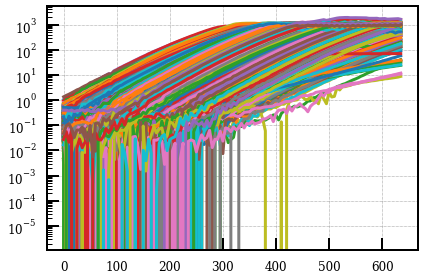

In [24]:
print(photoelectrons.shape)
plt.semilogy(ac_levels, photoelectrons.T)

# Gain

In [301]:
gain = mask_outliers(gain, n=2)

In [317]:
print(gain.mask.shape)
print(T[~gain.mask].shape)
plot_histo(gain, 'Gain [LSB $\cdot$ ns]', bins='auto', show_fit=True)
plot_histo(gain, 'Gain [LSB $\cdot$ ns]', bins='auto', show_fit=False)
plot_camera_display(gain, 'Gain [LSB $\cdot$ ns]')
plot_correlation(gain[~gain.mask], T[~gain.mask], T[~gain.mask], label_x='Gain [LSB $\cdot$ ns]', label_y='T [°C]', cmap=magma)

(1296,)
(1272,)


/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(1272,) (1272,)


# Electronic noise

In [319]:
sigma_e = mask_outliers(sigma_e, n=2)

In [321]:
plot_histo(sigma_e, '$\sigma_e$ [LSB $\cdot$ ns]', bins='auto', show_fit=True)
plot_histo(sigma_e, '$\sigma_e$ [LSB $\cdot$ ns]', bins='auto', show_fit=False)
plot_camera_display(sigma_e, '$\sigma_e$ [LSB $\cdot$ ns]')
plot_correlation(sigma_e[~sigma_e.mask], T[~sigma_e.mask], T[~sigma_e.mask], label_x='$\sigma_e$ [LSB $\cdot$ ns]', label_y='T [°C]', cmap=magma)

(1270,) (1270,)


# Sigma_s

In [323]:
sigma_s = mask_outliers(sigma_s, n=2)

In [325]:
plot_histo(sigma_s, '$\sigma_s$ [LSB $\cdot$ ns]', bins='auto', show_fit=True)
plot_histo(sigma_s, '$\sigma_s$ [LSB $\cdot$ ns]', bins='auto', show_fit=False)
plot_camera_display(sigma_s, '$\sigma_s$ [LSB $\cdot$ ns]')
plot_correlation(sigma_s[~sigma_s.mask], T[~sigma_s.mask], T[~sigma_s.mask], label_x='$\sigma_s$ [LSB $\cdot$ ns]', label_y='T [°C]', cmap=magma)

(1274,) (1274,)


# Baseline

In [353]:
baseline = mask_outliers(baseline, n=2)

In [354]:
plot_histo(baseline, 'Baseline [LSB $\cdot$ ns]', bins='auto', show_fit=True)
plot_histo(baseline, 'Baseline [LSB $\cdot$ ns]', bins='auto', show_fit=False)
plot_camera_display(baseline, 'Baseline [LSB $\cdot$ ns]')
plot_correlation(baseline[~baseline.mask], T[~baseline.mask], T[~baseline.mask], label_x='Baseline [LSB $\cdot$ ns]', label_y='T [°C]', cmap=magma)

(1225,) (1225,)


In [340]:
plot_calibration_ac_led(ac_levels, charge, gain, pixel=100, show_fit=False)

/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/ipykernel_launcher.py:19: InitialParamWarning: Parameter a does not have initial value. Assume 0.
/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/ipykernel_launcher.py:19: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/ipykernel_launcher.py:19: InitialParamWarning: Parameter b does not have initial value. Assume 0.
/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/ipykernel_launcher.py:19: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.


FCN = 17581.420680227122 
 TOTAL NCALL = 35 
 NCALLS = 35 
 
 
 EDM = 7.006309069346542e-19 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,5.70216e-06,9.87485e-09,0,0,,,
2,b,-23.5121,0.202256,0,0,,,


In [357]:
plot_transfer_function(charge, amplitude, 100)

/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/matplotlib/axes/_base.py:2923: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


In [26]:
plot_camera_display(transfer, label='amplitude / charge')
plot_histo(transfer, xlabel='amplitdude / charge', bins='auto')

In [27]:
plot_camera_display(gain_amplitude, label='Gain [LSB]')
plot_histo(gain_amplitude, xlabel='Gain [LSB]', bins='auto')

In [365]:
plot_histo(dark_count_rate * 1E3, 'DCR [MHz]', bins='auto', show_fit=False, limits=(0, 15))
plot_camera_display(dark_count_rate * 1E3, label='DCR [MHz]', cmap=magma, limits=(0, 15))
plot_correlation(dark_count_rate*1E3, T, T, label_x='DCR [MHz]', label_y='T [°C]', cmap=magma)

/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys


(1296,) (1296,)


In [155]:
plot_camera_display(sigma_e_amplitude, '$\sigma_e$ [LSB]', limits=(0, 1))

In [130]:
plot_correlation(gain, T, T, label_x='Gain [LSB $\cdot$ ns]', label_y='T [°C]', cmap=magma)

In [358]:
plot_correlation(gain, sigma_e, T, label_x='Gain [LSB $\cdot$ ns]', label_y='$\sigma_e$ [LSB $\cdot$ ns]', cmap=magma)

(1296,) (1296,)


In [64]:
plot_correlation(sigma_e, T, T, label_x='$\sigma_e$ [LSB $\cdot$ ns]', label_y='T [°C]', cmap=magma)

In [116]:
plot_correlation(sigma_s, T, T, label_x='$\sigma_s$ [LSB $\cdot$ ns]', label_y='T [°C]', cmap=magma)

In [118]:
plot_correlation(r, sigma_s, T, label_x='r [mm]', label_y='$\sigma_s$ [LSB $\cdot$ ns]', label_c='T [°C]', cmap=magma)

In [119]:
plot_correlation(r, T, T, label_x='r [mm]', label_y='T [°C]', label_c='T [°C]', cmap=magma)

In [120]:
plot_correlation(y, T, T, label_x='y [mm]', label_y='T [°C]', label_c='T [°C]', cmap=magma)

In [186]:
plot_camera_display(T, label='T [°C]', cmap=magma)
plot_histo(T, 'T [°C]', outliers=True, show_fit=True, bins='auto')

In [34]:
print(dark_count_rate.tolist())
print(sigma_e_amplitude.tolist())
print(sigma_s_amplitude.tolist())
print(gain_amplitude.tolist())
print(len(gain_amplitude.tolist()))

[0.0034146852667755623, 0.003056740868073615, 0.0026280994990132496, 0.003793063277453822, 0.0026960980453190077, 0.0023079253189687587, 0.0019776138135926243, 0.0026503430899324633, 0.0025471466779003094, 0.0025867891310923812, 0.002163000612708457, 0.001964665839099602, 0.003681486625939785, 0.01170126543909841, 0.002124684407386717, 0.0032626902522180272, 0.0021568105505496336, 0.0024049753584888577, 0.0019152928817057727, 0.0029993893257660707, 0.00225776728203895, 0.002897418613820079, 0.0025385801710718693, 0.002398882784879522, 0.0021008750733476364, 0.0027517229254793714, 0.002581392440275653, 0.002213595486014549, 0.0025911618196586632, 0.002060004478951982, 0.002361873836914716, 0.0024028884483123392, 0.0025867887663126015, 0.0023399188400119865, 0.002354533926454832, 0.0020004583354712043, 0.002025345028657217, 0.0025635202383705227, 0.002106210525344836, 0.002163310390616954, 0.002273463915560535, 0.0021265476113459404, 0.0019357149199395432, 0.0029917440211996737, 0.002474